In [4]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install keras
%pip install optuna


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging
import optuna



In [4]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [5]:
import yfinance as yf
vgt_data = yf.download("VGT", period = '5y')
voo_data = yf.download("VOO", period = '5y')
spy_data = yf.download('SPY', period = '5y')
data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [21]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    #Setting up hyperparameter tuners

    def optimizePPO(trial):
        return {
            'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
            'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
            'n_epochs' : int(trial.suggest_loguniform('n_epochs', 1, 48)),
            'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 1.)
        }

    def OptimizeA2C(trial):

        return {
            'n_steps': trial.suggest_int('n_steps', 16, 2048),
            'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef': trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'vf_coef': trial.suggest_loguniform('vf_coef', 0.5, 1.) 
        }

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Starting Hyperparameter Tuning...')

    
    def Optimize_PPO_agent(trial):
        model_params = optimizePPO(trial)
        env = env1
        model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward

    def Optimize_A2C_agent(trial):
        model_params = OptimizeA2C(trial)
        env = env1
        model = A2C('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward


    ppo_study = optuna.create_study()
    ppo_study.optimize(Optimize_PPO_agent, n_trials = 3)

    a2c_study = optuna.create_study()
    a2c_study.optimize(Optimize_A2C_agent, n_trials = 3)

    ppo_best_params = ppo_study.best_params
    ppo_best_params['clip_range'] = float(ppo_best_params['clip_range'])
    ppo_best_params['n_steps'] = int(ppo_best_params['n_steps'])
    ppo_best_params['n_epochs'] = int(ppo_best_params['n_epochs'])
    
    a2c_best_params = a2c_study.best_params

    logger.info(f'Hyperparameter tuning is complete. The A2C best parameters are: {a2c_best_params} and the best PPO parameters are: {ppo_best_params}')

    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1, **ppo_best_params)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1, **a2c_best_params)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=10000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=10000)

    logger.info('Training is complete')

    envs = [val_env1, val_env2, val_env3]

    def evalModel():

        num_years = 3
        counter = 3

        while counter <= num_years:

            for i in envs:
                ppo_rewards = []
                obs1 = i.reset()

                while True:
                    action, _ = ppo_agent.predict(obs1)
                    logger.info(f'PPO Took action {action} in state {obs1}')
                    obs, reward, done, info = i.step(action)
                    ppo_rewards.append(reward)

                    if done:
                        break

                print(f'PPO average validation for year {counter} reward: ', np.mean(ppo_rewards))


                a2c_rewards = []
                obs2 = val_env1.reset()

                while True:
                    action, _ = a2c_agent.predict(obs2)
                    obs, reward, done, info = val_env1.step(action)
                    a2c_rewards.append(reward)

                    if done:
                        break

                print(f'A2C average validation for year {counter} reward: ', np.mean(a2c_rewards))

                if np.mean(ppo_rewards) > np.mean(a2c_rewards):
                    agent = ppo_agent
                    action, _ = agent.predict(obs1)
                    print(f'Agent chosen for year {counter} is PPO')
                else:
                    agent = a2c_agent
                    action, _ = agent.predict(obs2)
                    print(f'Agent chosen for year {counter} is A2C')

                counter += 1
            

        



        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        #plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()
    evalModel()

    




[I 2023-08-01 19:20:00,449] A new study created in memory with name: no-name-fc59aa1a-6686-415e-9952-7c5b47c97ee3


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2259 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 284  |
-----------------------------


C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1218800471.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1218800471.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1218800471.py:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_

-------------------------------------------
| time/                   |               |
|    fps                  | 2117          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 568           |
| train/                  |               |
|    approx_kl            | 3.6388104e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.267         |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.000442      |
|    learning_rate        | 3.14e-05      |
|    loss                 | 3.04          |
|    n_updates            | 1             |
|    policy_gradient_loss | 0.000112      |
|    value_loss           | 8.26          |
-------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 719           |
|    ep_rew_mean          | 82.6          |
| time/                   |     

[I 2023-08-01 19:26:36,324] Trial 0 finished with value: -551.9063720703125 and parameters: {'n_steps': 284.31137113054183, 'gamma': 0.9104853159227843, 'learning_rate': 3.1441639553879466e-05, 'ent_coef': 0.026538358670900167, 'clip_range': 0.2666855781703652, 'n_epochs': 1.2393742146383744, 'gae_lambda': 0.892533804564229}. Best is trial 0 with value: -551.9063720703125.
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 826`, after every 12 untruncated mini-batches, there will be a truncated mini-batch of size 58
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=826 and n_envs=1)
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 26.9     |
| time/              |          |
|    fps             | 2301     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 826      |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 719       |
|    ep_rew_mean          | 29.9      |
| time/                   |           |
|    fps                  | 1830      |
|    iterations           | 2         |
|    time_elapsed         | 0         |
|    total_timesteps      | 1652      |
| train/                  |           |
|    approx_kl            | 60.051895 |
|    clip_fraction        | 0.985     |
|    clip_range           | 0.394     |
|    entropy_loss         | -0.0107   |
|    e

[I 2023-08-01 19:32:58,066] Trial 1 finished with value: -0.0 and parameters: {'n_steps': 826.0020889741543, 'gamma': 0.910162779555231, 'learning_rate': 0.3899599174190703, 'ent_coef': 1.029028820616516e-05, 'clip_range': 0.39354681559355953, 'n_epochs': 5.95337305649968, 'gae_lambda': 0.9936185554159785}. Best is trial 0 with value: -551.9063720703125.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2205 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 66   |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1225        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 132         |
| train/                  |             |
|    approx_kl            | 0.004628674 |
|    clip_fraction        | 0.033       |
|    clip_range           | 0.115       |
|    entropy_loss         | -0.692      |
|    explained_variance   | 0.0038      |
|    learning_rate        | 0.00156     |
|    loss                 | 15.7        |
|    n_updates            | 9           |
|    policy_gradient_loss | -0.000916   |
|    value_loss         

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 66`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 2
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=66 and n_envs=1)
  warnings.warn(


------------------------------------------
| time/                   |              |
|    fps                  | 1006         |
|    iterations           | 4            |
|    time_elapsed         | 0            |
|    total_timesteps      | 264          |
| train/                  |              |
|    approx_kl            | 0.0007515636 |
|    clip_fraction        | 0.299        |
|    clip_range           | 0.115        |
|    entropy_loss         | -0.675       |
|    explained_variance   | 0.0609       |
|    learning_rate        | 0.00156      |
|    loss                 | 5.98         |
|    n_updates            | 27           |
|    policy_gradient_loss | -0.000667    |
|    value_loss           | 10.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 973          |
|    iterations           | 5            |
|    time_elapsed         | 0            |
|    total_

[I 2023-08-01 19:39:40,513] Trial 2 finished with value: -1089.588623046875 and parameters: {'n_steps': 66.58899043960392, 'gamma': 0.9658636663072407, 'learning_rate': 0.0015625048604335369, 'ent_coef': 0.0023891890435053806, 'clip_range': 0.1150928788692191, 'n_epochs': 9.203785522550808, 'gae_lambda': 0.9090976569209026}. Best is trial 2 with value: -1089.588623046875.
[I 2023-08-01 19:39:40,514] A new study created in memory with name: no-name-836ac549-9456-4a74-a5c2-f3f2daeca6b9
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1218800471.py:70: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1218800471.py:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-01 19:46:11,991] Trial 0 finished with value: -2084.734130859375 and parameters: {'n_steps': 1943, 'gamma': 0.9924754915505685, 'learning_rate': 0.002341496455710321, 'ent_coef': 5.495254298275428e-08, 'vf_coef': 0.5011280330059593}. Best is trial 0 with value: -2084.734130859375.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-01 19:52:29,404] Trial 1 finished with value: 6.952492713928223 and parameters: {'n_steps': 676, 'gamma': 0.9612385656441886, 'learning_rate': 0.013010560386139352, 'ent_coef': 9.956015954128792e-07, 'vf_coef': 0.6455619584738519}. Best is trial 0 with value: -2084.734130859375.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-01 19:59:01,983] Trial 2 finished with value: -459.451416015625 and parameters: {'n_steps': 707, 'gamma': 0.9809981249960101, 'learning_rate': 0.0004509994579018275, 'ent_coef': 0.001689093406335143, 'vf_coef': 0.943670695912751}. Best is trial 0 with value: -2084.734130859375.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2205 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 66   |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1214        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 132         |
| train/                  |             |
|    approx_kl            | 0.008921215 |
|    clip_fraction        | 0.543       |
|    clip_range           | 0.115       |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.00541     |
|    learning_rate        | 0.00156     |
|    loss                 | 7.2         |
|    n_updates

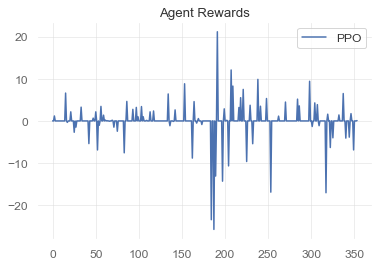

In [22]:
ModelCreation()

In [18]:
window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
        'stocks-v0',
        df = train_df,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

val_env1 = gym.make(
    'stocks-v0',
    df = val_df_1,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)




val_env2 = gym.make(
    'stocks-v0',
    df = val_df_2,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



val_env3 = gym.make(
    'stocks-v0',
    df = val_df_3,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])


n_cpu = 4

def optimizePPO(trial):
    return {
        'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
        'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
        'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
        'clip_range': trial.suggest_uniform('cliprange', 0.1, 0.4),
        'n_epochs' : int(trial.suggest_loguniform('noptepochs', 1, 48)),
        'gae_lambda': trial.suggest_uniform('lam', 0.8, 1.)
    }

def OptimizeA2C(trial):

  return {
    'n_steps': trial.suggest_int('n_steps', 16, 2048),
    'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
    'entropy_coef': trial.suggest_loguniform('entropy_coef', 1e-8, 1e-1),
    'value_loss_coef': trial.suggest_loguniform('value_loss_coef', 0.5, 1.) 
  }

n_steps = 0

def Optimize_PPO_agent(trial):
    model_params = optimizePPO(trial)
    env = env1
    model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
    model.learn(10000)

    rewards = []
    global n_steps

    n_episodes, reward_sum = 0, 0.0

    obs = env.reset()
    while n_episodes < 4:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        reward_sum += reward

        if done.all():
            rewards.append(reward_sum)
            reward_sum = 0.0
            n_episodes += 1
            obs = env.reset()

    last_reward = np.mean(rewards)
    trial.report(-1 * last_reward, step = n_steps)

    return -1 * last_reward


def Optimize_A2C_agent(trial):
    model_params = OptimizeA2C(trial)
    env = env1
    model = A2C('MlpPolicy', train_env, verbose=1, **model_params)
    model.learn(10000)

    rewards = []
    global n_steps

    n_episodes, reward_sum = 0, 0.0

    obs = env.reset()
    while n_episodes < 4:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        reward_sum += reward

        if done.all():
            rewards.append(reward_sum)
            reward_sum = 0.0
            n_episodes += 1
            obs = env.reset()

    last_reward = np.mean(rewards)
    trial.report(-1 * last_reward, step = n_steps)

    return -1 * last_reward

    

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [23]:
study = optuna.create_study()
study.optimize(Optimize_PPO_agent, n_trials = 1)



[I 2023-08-01 14:48:29,533] A new study created in memory with name: no-name-398a9f8a-a69a-45a5-bd86-7668e4da350c
C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1699 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 451  |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 719         |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 1329        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 902         |
| train/                  |             |
|    approx_kl            | 0.026152235 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.244       |
|    entropy_loss         | -0.679      |
|    explained_variance   | 0.0032      |
|    learning_rate        | 0.000444    |
|    loss               

[W 2023-08-01 14:55:10,560] Trial 0 failed with parameters: {'n_steps': 451.12033220489013, 'gamma': 0.9617187267622725, 'learning_rate': 0.000443853526740911, 'ent_coef': 0.028552271773859387, 'cliprange': 0.2439260175845944, 'noptepochs': 7.791510724032618, 'lam': 0.9594901554244898} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py", line 79, in Optimize_PPO_agent
    action, _ = model.predict(obs)
  File "C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\base_class.py", line 555, in predict
    return self.policy.predict(observation, 

KeyboardInterrupt: 

In [40]:
study.best_params

{'n_steps': 47.69492578331755,
 'gamma': 0.9210157662984991,
 'learning_rate': 9.977870235715527e-05,
 'ent_coef': 7.971129466598355e-06,
 'cliprange': 0.3076116027483111,
 'noptepochs': 5.248265181259201,
 'lam': 0.9777987276354275}

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'